In [0]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Preperation

In [0]:
#Loading des csv

path = '/content/drive/My Drive/DLMI/Data_challenge/'
output = pd.read_csv(path +"output_VSVxRFU.csv")

path_train = path +  "data_Q0G7b5t/"
clinical_data_train = pd.read_csv(path_train +"features/clinical_data.csv")
radiomics_train = pd.read_csv(path_train +"features/radiomics.csv")

path_test= path + "data_9Cbe5hx/"
clinical_data_test = pd.read_csv(path_test +"features/clinical_data.csv")
radiomics_test = pd.read_csv(path_test +"features/radiomics.csv")

radiomics_train.columns = ["PatientID"] + list(radiomics_train.iloc[0,1:])
radiomics_train = radiomics_train.iloc[2:,:]

radiomics_test.columns = ["PatientID"] + list(radiomics_test.iloc[0,1:])
radiomics_test = radiomics_test.iloc[2:,:]

clinical_data_train.set_index("PatientID", inplace=True)
clinical_data_test.set_index("PatientID", inplace=True)
radiomics_train.set_index("PatientID", inplace=True)
radiomics_test.set_index("PatientID", inplace=True)
output.set_index("PatientID",inplace=True)

submission_ex = pd.read_csv(path + "random_submission_0vhlEZN.csv")

In [0]:
#Path images train et test 
Path_image_train = path + "data_Q0G7b5t/images/"
Path_image_test = path + "data_9Cbe5hx/images/"

In the next chunk, we introduce some vizualisation of the masks and scans 

shape of scan is (92, 92, 92)
shape of mask is (92, 92, 92)


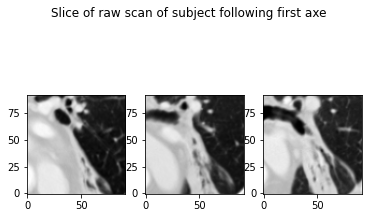

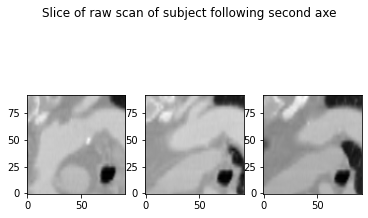

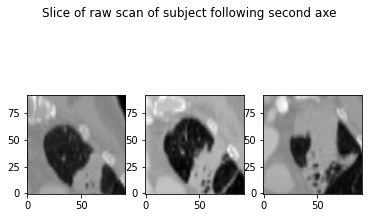

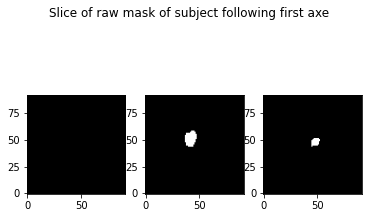

In [0]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

ex_archive = np.load(Path_image_train + 'patient_005.npz')
scan = ex_archive['scan']
mask = ex_archive['mask']

# scan.shape equals mask.shape

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")


print("shape of scan is " + str(scan.shape))
print("shape of mask is " + str(mask.shape))

slice_0 = scan[ :,:,1]
slice_1 = scan[ :,:,10]
slice_2 = scan[ :,:,20]
#plt.imshow(slice_0)
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw scan of subject following first axe")
plt.show()

slice_0 = scan[ 1,:,:]
slice_1 = scan[ 10,:,:]
slice_2 = scan[ 15,:,:]
#plt.imshow(slice_0)
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw scan of subject following second axe")
plt.show()


slice_0 = scan[ :,1,:]
slice_1 = scan[ :,10,:]
slice_2 = scan[ :,30,:]
#plt.imshow(slice_0)
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw scan of subject following second axe")
plt.show()


slice_0 = mask[ :,:,1]
slice_1 = mask[ :,:,30]
slice_2 = mask[ :,:,60]
#plt.imshow(slice_0)
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw mask of subject following first axe")
plt.show()


Below a function to transform scan if needed

In [0]:
import torchvision.transforms as T

trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                              std = [0.229, 0.224, 0.225])])



Below creation of the dataset class for the dataloading 

In [0]:
from torch.utils.data import Dataset, DataLoader, sampler

class OurDataset_train(Dataset):
    """This dataset includes .... """
    
    def __init__(self, img_dir, clinical_data,radiomics, output, transform=None):
        """
        Args:
            img_dir: (str) path to the images directory.
            clinical_data: (DataFrame) list of subjects with clinical data.
            radiomics: (DataFrame) list of subjects with 53 features on each.
            transform: Optional, transformations applied to ...
        """
        self.img_dir = img_dir
        self.radiomics = radiomics
        self.clinical_data = clinical_data
        self.transform = transform
        
        self.clinical_data = self.clinical_data.join(output,on='PatientID')
        self.clinical_data = self.clinical_data.reset_index()

        self.size = self[0]['scan'].shape
        
    def __len__(self):
        return len(self.clinical_data)

    def __getitem__(self, idx):
        """
        Args:
            idx: (int) the index of the subject/session whom data is loaded.
        Returns:
            sample: (dict) corresponding data described by the following keys:
                scan: 
                mask: 
                PatientID: 
                SourceDataset	
        """
        PatientID = self.clinical_data.loc[idx, 'PatientID']
        str_PID = str(PatientID)
        if len(str_PID) ==1:
          str_PID = "00"+str_PID
        elif len(str_PID) ==2:
          str_PID = "0"+str_PID

        SourceDataset = self.clinical_data.loc[idx, 'SourceDataset']

        #on peut carrément renvoyer la raw qui correspond dans clinical data et la 
        #raw qui correspond dans radiomics
        #C'est ce qu'il faut rajouter pour faire la regression de survival time

        filename = "patient_"+ str_PID + ".npz"
        with np.load(self.img_dir + filename) as image:
            scan = torch.from_numpy(image['scan']).type(torch.FloatTensor)#.unsqueeze(0)
            mask = torch.from_numpy(image['mask']).type(torch.FloatTensor)#.unsqueeze(0)

        #SurvivalTime = self.clinical_data.loc[idx, 'SurvivalTime'].astype(np.long)
        SurvivalTime = self.clinical_data.loc[idx, 'SurvivalTime'].astype(torch.FloatTensor)#.unsqueeze(0)
        if self.transform:
            scan = self.transform(scan)
            mask = self.transform(mask)

        sample = {'scan': scan, 'mask': mask,
                  'PatientID': PatientID,
                  'SurvivalTime' : SurvivalTime,
                  'SourceDataset': SourceDataset}
        return sample

    def train(self):
        """Put all the transforms of the dataset in training mode"""
        self.transform.train()

    def eval(self):
        """Put all the transforms of the dataset in evaluation mode"""
        self.transform.eval()

class OurDataset_test(Dataset):
    """This dataset includes .... """
    
    def __init__(self, img_dir, clinical_data,radiomics, transform=None):
        """
        Args:
            img_dir: (str) path to the images directory.
            clinical_data: (DataFrame) list of subjects with clinical data.
            radiomics: (DataFrame) list of subjects with 53 features on each.
            transform: Optional, transformations applied to ...
        """
        self.img_dir = img_dir
        self.radiomics = radiomics
        self.clinical_data = clinical_data
        self.transform = transform
        
        self.clinical_data = self.clinical_data.join(output,on='PatientID')
        self.clinical_data = self.clinical_data.reset_index()

        self.size = self[0]['scan'].shape
        
    def __len__(self):
        return len(self.clinical_data)

    def __getitem__(self, idx):

        PatientID = self.clinical_data.loc[idx, 'PatientID']
        str_PID = str(PatientID)
        if len(str_PID) ==1:
          str_PID = "00"+str_PID
        elif len(str_PID) ==2:
          str_PID = "0"+str_PID

        SourceDataset = self.clinical_data.loc[idx, 'SourceDataset']

        filename = "patient_"+ str_PID + ".npz"
        with np.load(self.img_dir + filename) as image:
            scan = torch.from_numpy(image['scan']).type(torch.FloatTensor)#.unsqueeze(0)
            mask = torch.from_numpy(image['mask']).type(torch.FloatTensor)#.unsqueeze(0)

        
        if self.transform:
            scan = self.transform(scan)

        sample = {'scan': scan, 'mask': mask,
                  'PatientID': PatientID,
                  'SourceDataset': SourceDataset}
        return sample

    def train(self):
        """Put all the transforms of the dataset in training mode"""
        self.transform.train()

    def eval(self):
        """Put all the transforms of the dataset in evaluation mode"""
        self.transform.eval()

## Building the model

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from time import time

Below we split the train dataset into a dataset to train our deep learning model and a dataset for evaluation

In [0]:
from sklearn.model_selection import train_test_split

idx = [i for i in range(len(clinical_data_train))]
idx_train, idx_val= train_test_split(idx,test_size = 0.2, random_state=42)
#penser à essayer avec 0.1

clinical_data_for_train = clinical_data_train.iloc[idx_train]
clinical_data_for_val = clinical_data_train.iloc[idx_val]

radiomics_for_train = radiomics_train.iloc[idx_train]
radiomics_for_val = radiomics_train.iloc[idx_val]

output_for_train = output.iloc[idx_train]
output_for_val = output.iloc[idx_val]

batch_size=5
dataset_train = OurDataset_train(Path_image_train, clinical_data_for_train, radiomics_for_train, output_for_train, transform=None)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val = OurDataset_train(Path_image_train, clinical_data_for_val, radiomics_for_val,output_for_val, transform=None)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)



In [0]:
dataset_test= OurDataset_test(Path_image_test, clinical_data_test, radiomics_test, transform=None)
dataloader_test = DataLoader(dataset_test, batch_size=1, drop_last=True)

Below the function to train and test the deep learning model

In [0]:
def train(model, train_loader, criterion, optimizer, n_epochs):
    """
    Method used to train a nn
    
    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping the dataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training

    Returns:
        best_model: (nn.Module) the trained neural network
    """
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        t0 = time()
        for i, data in enumerate(train_loader):
            images, mask = data['scan'], data['mask']
            outputs = model(images)
            loss = criterion(outputs, mask)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()

        mean_loss = total_loss / len(train_loader.dataset)
        print('Epoch %i: loss = %f' % (epoch, mean_loss))

        if mean_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = mean_loss
    
    return best_model

def test(model, data_loader, criterion):
    """
    Method used to test a CNN
    
    Args:
        model: (nn.Module) the neural network
        data_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
    
    Returns:
        results_df: (DataFrame) the label predicted for on the slice level.
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    columns = ["participant_id", "slice_id", "proba0", "proba1",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    batch_size = data_loader.batch_size
    n = data_loader.dataset.clinical_data.shape[0]

    n_batches = n//batch_size
    
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, masks = data['scan'], data['mask'] #unsqueeze(1)
            outputs = model(images)

            loss = criterion(outputs, masks)
            total_loss += loss.item()
            print("Batch {}/{} loss : {}".format(i+1, n_batches, str(total_loss/((i+1)*batch_size))))
       #     probs = nn.Softmax(dim=1)(outputs)
        #    _, predicted = torch.max(outputs.data, 1)

        """    for idx, sub in enumerate(data['participant_id']):
                row = [sub, data['slice_id'][idx], 
                       probs[idx, 0].item(), probs[idx, 1].item(),
                       labels[idx].item(), predicted[idx].item()]
                row_df = pd.DataFrame([row], columns=columns)
                results_df = pd.concat([results_df, row_df])"""
    print("Final loss : {}".format(str(total_loss/ len(data_loader.dataset))))
   # results_metrics = compute_metrics(results_df.true_label.values, results_df.predicted_label.values)
  #  results_df.reset_index(inplace=True, drop=True)
    
    
    ##return results_df, results_metrics


def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))
    
    metrics_dict = dict()
    metrics_dict['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sensitivity'] = tp / (tp + fn)
    else:
        metrics_dict['sensitivity'] = 0.0
        
    # Specificity
    if fp + tn != 0:
        metrics_dict['specificity'] = tn / (fp + tn)
    else:
        metrics_dict['specificity'] = 0.0
        
    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    
    return metrics_dict

We import a resnet18 trained on imagenet. We changed the first layer to adapat to our 2.5d (92 channels)
And we change the classfication layer into a regression layer.

In [0]:
import torch
import torch.nn as nn

In [0]:
class ConvBlock(nn.Module):
  def __init__(self, input_dim, middle_dim, output_dim):
    super().__init__()
    
    self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=2)
    self.conv2 = nn.Conv2d(input_dim, middle_dim, kernel_size=1, stride=2)
    self.conv3 = nn.Conv2d(middle_dim, middle_dim, kernel_size=1)
    self.conv4 = nn.Conv2d(middle_dim, output_dim, kernel_size=1)
    self.relu = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm2d(middle_dim)
    self.batchnorm2 = nn.BatchNorm2d(output_dim)
    self.batchnorm3 = nn.BatchNorm2d(2*output_dim)

  def forward(self, x):
    x1 = self.conv1(x)
    x1 = self.batchnorm2(x1)
    x = self.conv2(x)
    x = self.batchnorm1(x)
    x = self.conv3(x)
    x = self.batchnorm1(x)
    x2 = self.conv4(x)
    x = torch.cat([x1,x2], dim = 1)
    x = self.batchnorm3(x)
    x = self.relu(x)
    return x

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv = nn.Conv2d(92, 32, kernel_size=7)
    self.pool_conv = nn.ModuleList()
    self.pool_conv.append(ConvBlock(32, 32, 16))
    self.pool_conv.append(ConvBlock(32, 32, 16))
    self.pool_conv.append(ConvBlock(32, 48, 32))
    self.pool_conv.append(ConvBlock(64, 48, 32))

  def forward(self, x):
    x = self.conv(x)
    for layer in self.pool_conv:
      x = layer(x)
    return x

class Decoder(nn.Module):
    def __init__(self):
      super(Decoder, self).__init__()
      self.conv = nn.Conv2d(32, 92, kernel_size=7)
      self.pool_conv = nn.ModuleList()
      self.pool_conv.append(nn.Upsample(size=(11, 11)))
      self.pool_conv.append(ConvBlock(64, 48, 32))
      self.pool_conv.append(nn.Upsample(size=(22, 22)))
      self.pool_conv.append(ConvBlock(64, 48, 32))
      self.pool_conv.append(nn.Upsample(size=(43, 43)))
      self.pool_conv.append(ConvBlock(64, 32, 16))
      self.pool_conv.append(nn.Upsample(size=(92, 92)))
      self.pool_conv.append(ConvBlock(32, 32, 16))
      self.pool_conv.append(nn.Upsample(size=(98, 98)))

    def forward(self, x):
      for layer in self.pool_conv:
        x = layer(x)
      x = self.conv(x)
      return x

In [0]:
class RCAE(nn.Module):

    def __init__(self):
        super(RCAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def features(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

Training

In [0]:
learning_rate = 8e-4

model = RCAE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=3e-5)
n_epochs = 15

model = train(model, dataloader_train, criterion, optimizer, n_epochs)

Epoch 0: loss = 0.017231
Epoch 1: loss = 0.011261
Epoch 2: loss = 0.010750
Epoch 3: loss = 0.010479
Epoch 4: loss = 0.010272
Epoch 5: loss = 0.010120
Epoch 6: loss = 0.009901
Epoch 7: loss = 0.009745
Epoch 8: loss = 0.009608
Epoch 9: loss = 0.009529
Epoch 10: loss = 0.009643
Epoch 11: loss = 0.009396
Epoch 12: loss = 0.008956
Epoch 13: loss = 0.008893
Epoch 14: loss = 0.008996


Eval of the deep learning network

In [0]:
test(model,dataloader_val,criterion)

Batch 1/12 loss : 0.015452732145786286
Batch 2/12 loss : 0.022112707048654555
Batch 3/12 loss : 0.02080978701512019
Batch 4/12 loss : 0.021651213988661766
Batch 5/12 loss : 0.02129004955291748
Batch 6/12 loss : 0.0187318854033947
Batch 7/12 loss : 0.01746512640799795
Batch 8/12 loss : 0.016716383304446934
Batch 9/12 loss : 0.01672403092185656
Batch 10/12 loss : 0.016743004843592642
Batch 11/12 loss : 0.015835524689067494
Batch 12/12 loss : 0.015532918026049931
Final loss : 0.015532918026049931




```
# Ce texte est au format code
```

## Extracting the result for submission using only the deep learning network


In [0]:
from sklearn.model_selection import train_test_split

idx = [i for i in range(len(clinical_data_train))]
idx_train, idx_val= train_test_split(idx,test_size = 0.2, random_state=42)
#penser à essayer avec 0.1

clinical_data_for_train = clinical_data_train.iloc[idx_train]
clinical_data_for_val = clinical_data_train.iloc[idx_val]

radiomics_for_train = radiomics_train.iloc[idx_train]
radiomics_for_val = radiomics_train.iloc[idx_val]

output_for_train = output.iloc[idx_train]
output_for_val = output.iloc[idx_val]

batch_size=5
dataset_train = OurDataset_train(Path_image_train, clinical_data_for_train, radiomics_for_train, output_for_train, transform=None)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val = OurDataset_train(Path_image_train, clinical_data_for_val, radiomics_for_val,output_for_val, transform=None)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)



In [0]:
dataset_test= OurDataset_test(Path_image_test, clinical_data_test, radiomics_test, transform=None)
dataloader_test = DataLoader(dataset_test, batch_size=1, drop_last=True)

In [0]:
def calcul(model, loader):
  result=[]
  patientid=[]
  df = pd.DataFrame()
  for data in loader:
    images = data['scan']
    PatientId = int(data["PatientID"][0])
    y = (model.features(images)[0].detach().flatten().tolist())
    result.append(y)
    patientid.append(PatientId)
  return patientid,result

In [0]:
 PatientidTest, ResultforTest = calcul(model,dataloader_test) 

In [0]:
batch_size=1
dataset_train_1 = OurDataset_train(Path_image_train, clinical_data_for_train, radiomics_for_train, output_for_train, transform=None)
dataloader_train_1 = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val_1 = OurDataset_train(Path_image_train, clinical_data_for_val, radiomics_for_val,output_for_val, transform=None)
dataloader_val_1 = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)


PatientidTrain, ResultforTrain = calcul(model,dataloader_train_1) 
PatientidVal, ResultforVal = calcul(model,dataloader_val_1) 

## Adding clinical and radiomics feature to the deep learning predicted survival time

In [0]:
clinical_data_for_train = clinical_data_train.iloc[idx_train].reset_index().iloc[:,1:]
clinical_data_for_val = clinical_data_train.iloc[idx_val].reset_index().iloc[:,1:]

radiomics_for_a_train = radiomics_train.iloc[idx_train].reset_index().iloc[:,1:]
radiomics_for_a_val = radiomics_train.iloc[idx_val].reset_index().iloc[:,1:]

radiomics_a_test_1 = radiomics_test.reset_index().iloc[:,1:]
clinical_data_test_1 = clinical_data_test.reset_index().iloc[:,1:]

output_for_train = output.iloc[idx_train].reset_index().iloc[:,1]
output_for_val = output.iloc[idx_val].reset_index().iloc[:,1]


In [0]:
from sklearn import preprocessing

radiomics_for_train = preprocessing.scale(radiomics_for_a_train)
radiomics_for_val = preprocessing.scale(radiomics_for_a_val)
radiomics_test_1 = preprocessing.scale(radiomics_a_test_1)

from sklearn.decomposition import PCA

pca = PCA(n_components=10)

radiomics_for_train = pd.DataFrame(pca.fit_transform(radiomics_for_train))

radiomics_for_val = pd.DataFrame(pca.transform(radiomics_for_val))
radiomics_test_1 = pd.DataFrame(pca.transform(radiomics_a_test_1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [0]:
new_result_train = pd.DataFrame(columns = [str(i) +"s" for i in range(len(ResultforTrain[0]))])
for i in range(len(ResultforTrain)):
  new_result_train.loc[i] = ResultforTrain[i]

new_result_test = pd.DataFrame(columns = [str(i) +"s" for i in range(len(ResultforTest[0]))])
for i in range(len(ResultforTest)):
  new_result_test.loc[i] = ResultforTest[i]

new_result_val = pd.DataFrame(columns = [str(i) +"s" for i in range(len(ResultforVal[0]))])
for i in range(len(ResultforVal)):
  new_result_val.loc[i] = ResultforVal[i]

ResultTrain = preprocessing.scale(new_result_train)
ResultVal = preprocessing.scale(new_result_val)
ResultTest = preprocessing.scale(new_result_test)

otherpca = PCA(n_components=10)

new_result_train = pd.DataFrame(otherpca.fit_transform(ResultTrain))

new_result_val = pd.DataFrame(otherpca.transform(ResultVal))
new_result_test = pd.DataFrame(otherpca.transform(ResultTest))

In [0]:
pca.explained_variance_ratio_


array([0.49514637, 0.15568133, 0.07914132, 0.05486399, 0.04978658,
       0.03980908, 0.02640242, 0.022413  , 0.01642615, 0.01562686])

In [0]:
otherpca.explained_variance_ratio_

array([0.1095889 , 0.06673336, 0.05111265, 0.04459542, 0.03294866,
       0.02489739, 0.02258693, 0.0208991 , 0.01829863, 0.01628899])

In [0]:
from skimage.filters import gabor
import scipy.ndimage as nd

def gabor_apply(loader):
  gabor_res=[]

  theta_v = [0.2*i for i in range(1,6)]
  sigma = [i for i in range(1,6)]
  freq = [i*0.1 for i in range(1,6)]

  for data in loader:
    y = []

    for i in range(5):
      image = np.array(data['scan'][0].tolist())
      temp =  np.array([[[0 for i in range(image.shape[0])]for j in range(image.shape[1])]for k in range(image.shape[2])])
      for k in range(image.shape[2]):
        temp[:,:,k],_ = gabor(image[:,:,k], frequency= freq[i], theta = theta_v[i] * np.pi,sigma_x=sigma[i], sigma_y=sigma[i])

      mean = temp.mean()
      variance = temp.var()
      max_v = np.max(temp)
      min_v = np.min(temp)

      y += [variance, mean, max_v, min_v]
    
    gabor_res.append(y)
  
  return gabor_res

gabor_train = gabor_apply(dataloader_train_1)
gabor_val = gabor_apply(dataloader_val_1)
gabor_test = gabor_apply(dataloader_test)

In [0]:
new_gabor_train = pd.DataFrame(columns = [str(i) +"g" for i in range(len(gabor_train[0]))])
for i in range(len(gabor_train)):
  new_gabor_train.loc[i] = gabor_train[i]

new_gabor_test = pd.DataFrame(columns = [str(i) +"g" for i in range(len(gabor_test[0]))])
for i in range(len(gabor_test)):
  new_gabor_test.loc[i] = gabor_test[i]

new_gabor_val = pd.DataFrame(columns = [str(i) +"g" for i in range(len(gabor_val[0]))])
for i in range(len(gabor_val)):
  new_gabor_val.loc[i] = gabor_val[i]

GaborTrain = preprocessing.scale(new_gabor_train)
GaborVal = preprocessing.scale(new_gabor_val)
GaborTest = preprocessing.scale(new_gabor_test)

lastpca = PCA(n_components=9)

gabortrain = pd.DataFrame(lastpca.fit_transform(GaborTrain))
gaborval = pd.DataFrame(lastpca.transform(GaborVal))
gabortest = pd.DataFrame(lastpca.transform(GaborTest))

In [0]:
lastpca.explained_variance_ratio_

array([0.55715714, 0.1596259 , 0.06921425, 0.05203703, 0.03980934,
       0.03435112, 0.02878551, 0.0160287 , 0.01361433])

In [0]:
#df_train = pd.concat([radiomics_for_train,new_result_train, clinical_data_for_train, gabortrain],axis=1)
df_train = pd.concat([radiomics_for_train,new_result_train, clinical_data_for_train],axis=1)
#df_test =  pd.concat([radiomics_test_1,new_result_test, clinical_data_test_1, gabortest],axis=1)
df_test =  pd.concat([radiomics_test_1,new_result_test, clinical_data_test_1],axis=1)
#df_val = pd.concat([radiomics_for_val,new_result_val, clinical_data_for_val, gaborval],axis=1)
df_val = pd.concat([radiomics_for_val,new_result_val, clinical_data_for_val],axis=1)

df_val.columns = [str(i) for i in range(len(df_val.columns))]
df_test.columns = [str(i) for i in range(len(df_test.columns))]
df_train.columns = [str(i) for i in range(len(df_train.columns))]
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,7.620663,0.486540,-1.266777,0.666230,1.694296,1.467677,0.702404,-0.575716,-1.636755,0.124355,1.091307,-13.109280,-8.811534,1.684406,6.602840,0.122457,-4.198642,-5.282022,-4.912086,-11.504831,large cell,0,0,l1,4,79.1020
1,5.506842,6.505225,-1.153755,0.132907,-2.314646,6.345224,0.965414,-1.385246,-0.002879,1.173201,-9.808393,-21.379479,-4.552587,-10.094890,-0.973086,1.931392,4.270851,4.903780,11.515579,2.042567,Adenocarcinoma,0,1,l2,3,56.0000
2,6.067549,-1.522951,2.383400,0.797296,-0.790221,0.201712,0.417272,3.872932,2.006415,-0.641047,-15.268743,-23.139125,-2.727551,3.054034,-2.588198,-8.537570,4.365630,0.535834,1.181997,-2.583650,squamous cell carcinoma,0,0,l1,3,78.7105
3,-2.918245,3.643165,0.070701,1.411236,-1.843138,-2.181853,-0.212374,-0.605711,-0.427247,-0.173680,-8.069721,2.922952,7.136775,-9.055012,-4.906395,-4.347223,-11.176056,-0.044798,0.754363,16.247639,Adenocarcinoma,0,2,l2,2,74.0000
4,-1.547518,-2.811621,-0.085715,1.226051,-0.734835,-0.775082,0.078228,-0.636443,0.834932,-0.210428,24.057751,-8.173829,3.726584,-7.092636,21.049814,-5.922323,-1.440937,2.586224,-8.398267,9.217543,Adenocarcinoma,0,0,l2,1,62.0000


In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 59kB/s 


 RMSE, MultiRMSE, MAE, Quantile, LogLinQuantile, Poisson, MAPE, Lq or custom objective object

In [0]:
from catboost import Pool, CatBoostRegressor
from catboost import CatBoost

categorical_features_indices=[20,23]
df_train = df_train.replace(np.nan, '', regex=True)
train_dataset = Pool(df_train, b_train,cat_features=categorical_features_indices)

df_val = df_val.replace(np.nan, '', regex=True)
eval_dataset = Pool(df_val, b_val,cat_features=categorical_features_indices)




modelcat = CatBoostRegressor(loss_function='QueryRMSE')

grid = {
        'learning_rate': [0.03,0.05,0.04,0.01,0.02, 0.07,0.1, 0.2, 0.3],
        'depth': [1, 2,3],
        'l2_leaf_reg': [1,2, 3,4, 5, 6,7, 8,9]
        
        }

grid_search_result = modelcat.grid_search(grid, 
                                       X=train_dataset,
                                       cv=5,  
                                       plot=True
                                       )

#model1 = CatBoostRegressor(grid_search=grid_search_result, loss_function='RMSE')
#model.fit(train_dataset, eval_set=eval_dataset, verbose=False)



In [0]:
preds = modelcat.predict(eval_dataset)
print(list(output_for_val))
print(preds)
from sklearn.metrics import mean_squared_error
mean_squared_error(list(output_for_val),preds)

[457, 316, 1145, 196, 131, 155, 1359, 213, 706, 1070, 98, 756, 1315, 312, 1309, 303, 928, 618, 134, 31, 244, 325, 66, 965, 65, 527, 1295, 1540, 728, 2309, 25, 2145, 2158, 907, 510, 1392, 1369, 136, 739, 714, 131, 96, 1456, 1425, 515, 463, 1099, 293, 24, 3078, 515, 635, 1315, 632, 559, 265, 1962, 491, 1172, 132]
[ 700.65548734  267.25907564  933.05469728  757.29448427  747.54456134
  240.84921846  384.06908379  624.54411767  985.14374974 1245.96157486
  651.149612    100.69595479  478.59925549  979.60467593  579.48530689
  789.37278902  931.60635914  744.04744011  710.6073435   929.28411075
  705.83874598  665.41658639  981.95603402  901.39089014  577.06411622
  809.29389629  536.96990094 1128.06703549  574.13523181 1473.3674041
  429.63031153 1698.78025916 1608.87121724 1156.80388383  395.28786667
  214.4779532   978.85845252  855.59632552  869.68204911  250.60669866
  -46.56146505  679.63959504 1938.84690188 2034.96280475 1388.29950262
 1551.3295841   435.27051195  530.75713357  350.2

336192.80326398456

In [0]:
df_test = df_test.replace(np.nan, '', regex=True)


preds = modelcat.predict(df_test)
submission_ex = pd.read_csv(path + "random_submission_0vhlEZN.csv")
submission_ex["SurvivalTime"] = preds
submission_ex.set_index("PatientID", inplace=True)

submission_ex[submission_ex['SurvivalTime'] <0]  = np.pi/3
#submission_ex['SurvivalTime'] = submission_ex['SurvivalTime'].astype(int)
submission_ex.to_csv("submission_8.csv")
print(submission_ex[submission_ex['SurvivalTime'] <1] )
print(submission_ex)


Empty DataFrame
Columns: [SurvivalTime, Event]
Index: []
           SurvivalTime  Event
PatientID                     
13           378.292968    NaN
155          814.768410    NaN
404          719.928699    NaN
407         1176.293827    NaN
9           1574.538966    NaN
...                 ...    ...
66           252.546469    NaN
132          678.316772    NaN
169          895.035442    NaN
199          764.958949    NaN
274          420.859380    NaN

[125 rows x 2 columns]
